## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $10D$ Ackley function on the domain $[-10, 15]^{10}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)


In [1]:
from reservoir import *
import torch
import numpy as np
import time
import pylab as pl
from IPython import display

device: cpu


### Load data and train test split

In [2]:
data = np.loadtxt('MackeyGlass_t17.txt')

tr_len = 2000
te_end = 2500 #6000

train = torch.FloatTensor(data[:tr_len].reshape(-1, 1))
test = torch.FloatTensor(data[tr_len:te_end].reshape(-1, 1))

## Train a simple RC with arbitrary hyper parameters

GENERATING IN WEIGHTS


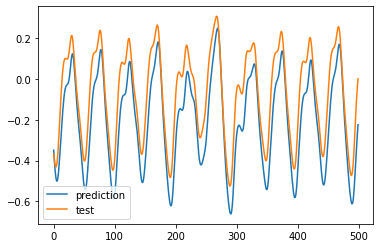

In [3]:
#n_nodes=1000, connectivity=0.01, input_scaling=0.5, feedback_scaling=0.5, leaking_rate=0.3, spectral_radius=1.25, regularization=1e-8, feedback=True)
torch.manual_seed(1)
RC = EchoStateNetwork(n_nodes=1000, connectivity=0.1, input_scaling=1, feedback_scaling=1, 
         leaking_rate=0.1, spectral_radius=0.96, regularization=1e-3, feedback=True, backprop = False, epochs = 20,
         activation_f = sinsq) #bias = -10,

RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 1)
plt.plot(pred, label = "prediction")
plt.plot(test, label = "test")
plt.legend();

## optimize

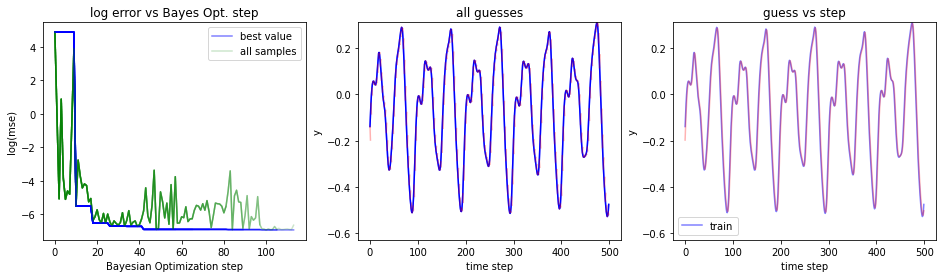

0.4708270225368562
CPU times: user 1min 32s, sys: 26.4 s, total: 1min 58s
Wall time: 1min 34s


{'spectral_radius': 0.9808752061571184,
 'connectivity': -2.576501186023308,
 'regularization': -2.2822993808904517,
 'leaking_rate': 0.6323979116226648,
 'feedback_scaling': 0.0011988461282328644,
 'input_scaling': 0.4999056360582697}

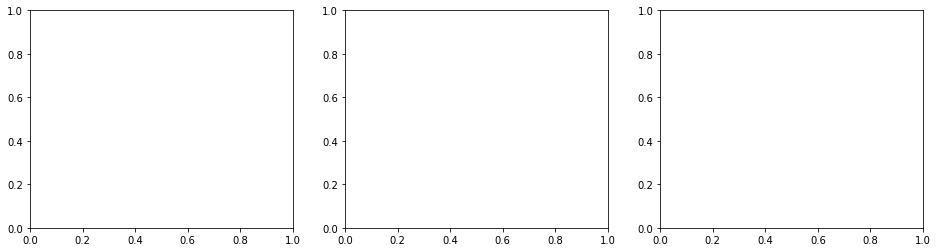

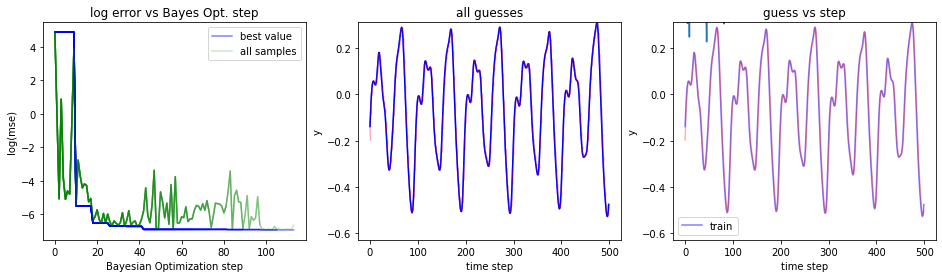

In [4]:
%%time
%matplotlib inline
#### eps isn't what it used to be.

bounds_dict = {"spectral_radius" : (0,1), 
               "connectivity" : (-5,0), 
               "regularization": (-5,-2),
               "leaking_rate" : (0, 1),
               "feedback_scaling" : (0,1),
               "input_scaling" : (0,1),
               #"bias" : "uniform",#(-3,3),
               "n_nodes" : 1000, 
               "feedback": 1}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 1, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 10, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = False, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)

pl.plot(esn_cv.iteration_durations)
print(np.mean(esn_cv.iteration_durations))
vals

In [5]:
vals_ = vals.copy()
vals_["connectivity"] = 10**(vals_["connectivity"])
vals_["regularization"] = 10**(vals_["regularization"])

## Optimized RC test set score (with feedback)

GENERATING IN WEIGHTS


Text(0.5, 1.0, 'Optimized RC')

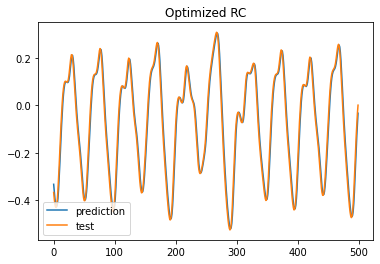

In [7]:
RC = EchoStateNetwork(**vals_, feedback=True, backprop = False, epochs = 20,
         activation_f = sinsq)
RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 1)


plt.plot(pred, label = "prediction")
plt.plot(test, label = "test")
plt.legend();
plt.title("Optimized RC")


In [ ]:
assert 1 == 0

In [ ]:
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.generation import MaxPosteriorSampling
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

#other packages
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import time
import pandas as pd

dtype=torch.float 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
print("device:", device)

In [ ]:
plt.plot(pred)

## Optimize the 10-dimensional Ackley function

The goal is to minimize the popular Ackley function:

$f(x_1,\ldots,x_d) = -20\exp\left(-0.2 \sqrt{\frac{1}{d} \sum_{j=1}^d x_j^2} \right) -\exp \left( \frac{1}{d} \sum_{j=1}^d \cos(2 \pi x_j) \right) + 20 + e$

over the domain  $[-10, 15]^{10}$.  The global optimal value of $0$ is attained at $x_1 = \ldots = x_d = 0$.

As mentioned above, since botorch assumes a maximization problem, we instead maximize $-f(x)$.

#fun = Ackley(dim=10, negate=True).to(dtype=dtype, device=device)
#fun.bounds[0, :].fill_(-10)
#fun.bounds[1, :].fill_(15)
#dim = fun.dim
#lb, ub = fun.bounds

#def eval_objective(x):
#    """This is a helper function we use to unnormalize and evalaute a point"""
#    return fun(unnormalize(x, fun.bounds))

In [ ]:
%%time

torch.autograd.set_detect_anomaly(True)

def printn(param: torch.nn.parameter):
    print(param._name_ + "\t \t", param.shape)

def NRMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2)/y**2)
    

class EchoStateNetwork(nn.Module):
    def __init__(self, spectral_radius=0.9, n_nodes = 1000, activation_f = nn.Tanh(), feedback = True,
                 noise = 0, input_scaling = 0.5, leaking_rate = 0.99, regularization = 10 **-3, backprop = False,
                 criterion = nn.NLLLoss(), classification = False, output_size = 50, feedback_scaling = 0.5,
                 already_normalized = True, bias = "uniform", connectivity = 0.1, random_state = 123,
                 exponential = False, obs_idx = None, resp_idx = None,
                 reservoir = None, model_type = "uniform", input_weight_type = None, approximate_reservoir = True,
                 device = device, epochs = 7):
        super().__init__()
        
        self.epochs = epochs
        
        #faster, approximate implimentation
        self.approximate_reservoir = approximate_reservoir
        self.reservoir = reservoir
        
        # is this obselete? check.
        self.already_normalized = already_normalized
        
        # backprop, feedback, random state and device ('cuda' or not)
        self.backprop = backprop
        self.device = torch.device(device)
        self.feedback = feedback
        self.random_state = torch.Generator(device=self.device).manual_seed(random_state)
        self.tensor_args = {"device": self.device, "generator" : self.random_state}
        
        # hyper-parameters:
        self.bias = bias
        self.connectivity = connectivity
        self.feedback_scaling = feedback_scaling
        self.input_scaling = input_scaling
        self.leaking_rate = leaking_rate
        self.noise = noise
        self.n_nodes = n_nodes
        self.spectral_radius = spectral_radius
        self.regularization = regularization
        
        #activation
        self.activation_function = activation_f
        
        #backprop layers
        #self.LinIn = nn.Linear(input_size, n_nodes)
        #self.LinH = nn.Linear(n_nodes, n_nodes, bias = False)
        #self.LinOut = nn.Linear(n_nodes, output_size)
        
        #https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19
        self.classification = classification
        if self.classification:
            self.log_reg = torch.nn.Linear(self.n_nodes, 2)
            self.criterion = criterion #torch.nn.CrossEntropyLoss()
        else:
            self.criterion = nn.MSELoss()
            
        with torch.no_grad():
            self.gen_reservoir()
    
    def plot_reservoir(self):
        sns.histplot(self.weights.numpy().view(-1,))
        
    def forward(self, t, input_, current_state):
        """
        Arguments:
        
        """
        with torch.no_grad():
            in_vec     = torch.matmul(self.in_weights, input_)
        weight_vec = torch.matmul(self.weights, current_state)
        
        vec    = in_vec + weight_vec
        update = self.activation_function(vec)

        current_hidden_state = self.leaking_rate * update + (1 - self.leaking_rate) * current_state  # Leaking separate
        current_hidden_state = current_hidden_state.view(1,-1)
        
        with torch.no_grad():
            self.state[t, :] = current_hidden_state.detach().squeeze()
            
        if self.classification:
            output = self.ClassOut(current_hidden_state)
        else:
            #output = self.out_weights @ current_hidden_state
            if self.backprop:
                if self.feedback:
                    
                    vec = torch.cat([input_[1].view(-1,1), current_hidden_state], 1)

                    output = self.LinOut(vec)
                else:    
                    output = self.LinOut(current_hidden_state.view(-1,1))
            else:
                output = None
        
        return current_hidden_state, output #, hidden_dot, output_dot
      
    """
    def gen_reservoir(self, spectral_radius = 0.5):
        #
        #generate the reservoir.
        #
        with torch.no_grad():
            res_weights = torch.FloatTensor(self.n_nodes, self.n_nodes).uniform_(-1, 1, generator = self.random_state)
            accept = torch.FloatTensor(self.n_nodes, self.n_nodes).uniform_(0, 1, generator = self.random_state)
            accept = accept<self.connectivity
            #print(accept.sum()/(len(accept.view(-1,1))))
            res = accept * res_weights
            radius = (res.eig(eigenvectors = False)[0].abs().max())
            weights = nn.Parameter(res*self.spectral_radius/radius, requires_grad = False).to(device)
        return weights
    """
    
    def gen_reservoir(self, obs_idx = None, targ_idx = None, load_failed = None):
        """Generates random reservoir from parameters set at initialization."""
        # Initialize new random state
        start = time.time()
        #random_state = np.random.RandomState(self.random_state)
        max_tries = 1000  # Will usually finish on the first iteration
        n = self.n_nodes

        #if the size of the reservoir has changed, reload it.
        if self.reservoir:
            if self.reservoir.n_nodes_ != self.n_nodes:
                load_failed = 1

        book_index = 0
        for i in range(max_tries):
            if i > 0:
                printc(str(i), 'fail')
            #only initialize the reservoir and connectivity matrix if we have to for speed in esn_cv.
            if not self.reservoir or not self.approximate_reservoir or load_failed == 1:

                self.accept = torch.rand(self.n_nodes, self.n_nodes, **self.tensor_args)

                self.weights = torch.rand(self.n_nodes, self.n_nodes, **self.tensor_args)#), generator = self.)

                self.weights = self.weights * 2 - 1 
                self.weights *= self.accept

                #self.weights = csc_matrix(self.weights)
            else:
                #print("LOADING MATRIX", load_failed)
                if self.approximate_reservoir:
                
                    try:   
                        self.weights = self.reservoir.get_approx_preRes(self.connectivity, i)
                        self.weights = self.weights.to(device)
                        #printc("reservoir successfully loaded (" + str(self.weights.shape) , 'green') 
                    except:
                        printc("approx reservoir " + str(i) + " failed to load... regenerating", 'fail')

                        #skip to the next iteration of the loop
                        if i > self.reservoir.number_of_preloaded_sparse_sets:
                            load_failed = 1
                            printc("All preloaded reservoirs Nilpotent, generating random reservoirs." + ", connectivity =" + str(round(self.connectivity,8)) + '...regenerating', 'fail')
                        continue
                else:
                    assert 1 == 0, "TODO, case not yet handled."
             
            max_eigenvalue = self.weights.eig(eigenvectors = False)[0].abs().max()
            
            if max_eigenvalue > 0:
                break
            else:
                printc("Loaded Reservoir is Nilpotent (max_eigenvalue =" + str(max_eigenvalue) + "), connectivity =" + str(round(self.connectivity,8))  + '...regenerating', 'fail')
                #if we have run out of pre-loaded reservoirs to draw from :
                if i == max_tries - 1:
                    raise ValueError('Nilpotent reservoirs are not allowed. Increase connectivity and/or number of nodes.')

        # Set spectral radius of weight matrix
        self.weights = self.weights * self.spectral_radius / max_eigenvalue
        self.weights = nn.Parameter(self.weights, requires_grad = False)
        
        if load_failed == 1 or not self.reservoir:
            self.state = torch.zeros(1, self.n_nodes, device=torch.device(device)) #Variable)
        else:
            self.state = self.reservoir.state

        # Set out to none to indicate untrained ESN
        self.out_weights = None
             
    def set_Win(self, inputs):
        """
        Build the input weights.
        Currently only uniform implimented.
        """
        with torch.no_grad():
            
            if not self.reservoir or 'in_weights' not in dir(self.reservoir): 
                print("GENERATING IN WEIGHTS")

                in_weights = torch.rand(self.n_nodes, self.n_inputs, generator = self.random_state, device = self.device)
                in_weights =  in_weights * 2 - 1
                
                if self.bias == "uniform":
                    #random uniform distributed bias
                    bias = torch.rand(self.n_nodes, 1, generator = self.random_state, device = self.device)
                    bias = bias * 2 - 1
                else:
                    bias = torch.ones(self.n_nodes, 1, device = self.device)*self.bias

                #if there is white noise add it in (this will be much more useful later with the exponential model)
                if self.noise:
                    white_noise = torch.normal(0, self.noise, device = self.device, size = (self.n_nodes, n_inputs))
                    in_weights += white_noise

                in_weights = torch.hstack((bias, in_weights)) * self.input_scaling
                
                if self.feedback:
                    feedback_weights = torch.rand(self.n_nodes, 1, device = self.device, generator = self.random_state) * 2 - 1
                    feedback_weights = self.feedback_scaling * feedback_weights
                    in_weights = torch.hstack((in_weights, feedback_weights)).view(self.n_nodes, -1)
                
            else:
                #print("self.reservoir.in_weights", self.reservoir.in_weights.get_device())
                #print("self.reservoir.noise_z", self.reservoir.noise_z.get_device())
                #print("feedback", self.reservoir.feedback_weights.get_device())
                in_weights = self.reservoir.in_weights + self.noise * self.reservoir.noise_z
                
                if self.feedback:
                    feedback_weights = self.feedback_scaling * self.reservoir.feedback_weights
                    in_weights = torch.hstack((in_weights, feedback_weights)).view(self.n_nodes, -1)
   
        in_weights = nn.Parameter(in_weights, requires_grad = False).to(self.device)
        in_weights._name_ = "in_weights"
        return(in_weights)
    
        """
        if not self.reservoir or 'in_weights' not in dir(self.reservoir): 
            
            if self.input_weight_type in ["exponential", "uniform"]:
                n_inputs = (y.shape[1] - 1) if x is None else x.shape[1]
                self.n_inputs = n_inputs
                print('in weight type', self.input_weight_type)
                if self.input_weight_type == "exponential":
                    #print("EXP")
                    self.get_exp_weights(x.shape[1])
                    
                    if self.reservoir:
                        uniform_bias = self.reservoir.uniform_bias
                        #print("BUILDING EXPONENTIAL IN WEIGHTS" )
                    else:
                        uniform_bias = random_state.uniform(-1, 1, size = (self.n_nodes, 1))
                    self.in_weights =  self.exp_weights
                else:
                    print("BUILDING UNIFORM IN WEIGHTS")
                    
                    self.in_weights = random_state.uniform(-1, 1, size=(self.n_nodes, n_inputs))
                    uniform_bias = random_state.uniform(-1, 1, size = (self.n_nodes, 1))

                
                 #* self.bias_scaling
                if self.noise:
                    white_noise = random_state.normal(loc = 0, scale = self.noise, size = (self.n_nodes, n_inputs)) #self.in_weights.shape[1] - 1
                    #print(self.in_weights.shape, "in_weights")
                    #print(white_noise.shape, "white noise")
                    self.in_weights += white_noise
                self.in_weights = np.hstack((uniform_bias, self.in_weights)) * self.input_scaling

                #self.reservoir.in_weights = self.in_weights

            elif self.input_weight_type == "cyclic":

                # Set and scale input weights (for memory length and non-linearity)
                self.in_weights = np.full(shape=(self.n_nodes, inputs.shape[1] - 1), fill_value=self.cyclic_input_w, dtype=np.float32)
                self.in_weights *= np.sign(random_state.uniform(low=-1.0, high=1.0, size=self.in_weights.shape))
                self.in_weights *= self.input_scaling 
                
                #add input bias
                cyclic_bias = np.full(shape=(self.n_nodes, 1), fill_value=self.cyclic_bias, dtype=np.float32)
                cyclic_bias *= np.sign(random_state.uniform(low=-1.0, high=1.0, size=self.cyclic_bias.shape))
                
                self.in_weights = np.hstack((cyclic_bias, self.in_weights)) 
                self.input_weights_from_cv = self.in_weights
        else:
            #print("loading in_weights from cv.")
            self.in_weights = self.reservoir.in_weights + self.noise * self.reservoir.noise_z
        
        
        """
        
    def display_in_weights(self):
        sns.heatmap(self.in_weights)
    def display_out_weights(self):
        sns.heatmap(self.out_weights)
    def display_res_weights(self):
        sns.heatmap(self.weights)
    def plot_states(self, n= 10):
        for i in range(n):
            plt.plot(list(range(len(self.state[:,i]))), RC.state[:,i], alpha = 0.8)
        
    def train(self, y, x=None, burn_in=0, input_weight=None, verbose = False ,learning_rate = None):
        """
        Train the network.
        
        Arguments:
            y: response matrix
            x: observer matrix
            burn in: obvious
            input_weight : ???
            
        """
        #h  = Variable(torch.zeros([Nt,self.reservoir_size]), requires_grad = False)
        #zd = Variable(torch.zeros(Nt), requires_grad = False)
        #z  = Variable(torch.zeros(Nt), requires_grad = False)
        
        #TODO : torch random state
        
        #build the state matrix:
        #with torch.no_grad():
        #if x:
        #    x = x.to(device)
        #y = y.to(device)
        
        start_index = 1 if self.feedback else 0 
        rows = y.shape[0] - start_index
        
        # Normalize inputs and outputs
        y = self.normalize(outputs=y, keep=True)
        
        if not x is None:
            x = self.normalize(inputs=x, keep=True)
            self.n_inputs = (x.shape[1])
    
        if x is None and not self.feedback:
            #raise ValueError("Error: provide x or enable feedback")
            self.already_normalized = True
            inputs = torch.ones((y.shape[0], y.shape[1] + 1), device = self.device)
            self.n_inputs  = y.shape[1]
        
        if x is None and self.feedback:
            self.n_inputs  = y.shape[1] - 1
            
        self.state = torch.zeros((rows, self.n_nodes), device = self.device)
        self.state._name_ = "state"
        #self.state = self.state.detach()
        current_state = self.state[-1] 
        
        #concatenate a column of ones to the input x for bias.
        inputs = torch.ones(rows, 1, device = self.device)
        inputs.requires_grad=False
        
        #initialize the in_weights and bias tensors
        if not x is None:
            inputs = torch.hstack((inputs, x[start_index:]))
        elif self.feedback:
            inputs = torch.hstack((inputs, y[:-1])) 
        else:
            inputs = torch.rand(inputs.shape[0], 2, generator = self.random_state, device = self.device) * 2 -1#torch.hstack((inputs, inputs)) 

        self.in_weights = self.set_Win(inputs)
        inputs._name_ = "inputs"
        
        #output weights
        if self.feedback:
            self.LinOut = nn.Linear(1 + self.n_nodes, y.shape[1]).to(device)
        else:
            self.LinOut = nn.Linear(self.n_nodes, y.shape[1]).to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        for i in range(5):
            try:
                param = next(hi)
                if param.requires_grad:
                    print(f'parameter {i}',param.shape)
            except:
                pass
        self.burn_in = burn_in
            
        #fast exact solution ie we don't want to run backpropogation (ie we aren't doing classification):
        if not self.backprop:
            with torch.no_grad():

                for t in range(inputs.shape[0]):

                    hidden, output = self.forward(t, inputs[t].T, current_state)

                complete_data = torch.hstack((inputs, self.state))
                complete_data._name_ = "complete_data"

                train_x = complete_data[burn_in:]  # Include everything after burn_in
                train_y = y[burn_in + 1:] if self.feedback else y[burn_in:]

                # Ridge regression
                ridge_x = torch.matmul(train_x.T, train_x) + \
                            self.regularization * torch.eye(train_x.shape[1], device = self.device) #.to(device)
                ridge_y = torch.matmul(train_x.T, train_y)

                # Solver solution (fast)
                out_weights_sol = torch.solve(ridge_y, ridge_x)
                self.out_weights = out_weights_sol.solution
                self.out_weights._name_ = "out_weights"

        else:
            # backprop:
            print(5)
            running_loss = 0
            train_losses = []
            for e in range(self.epochs):
                optimizer.zero_grad()
                loss = 0
                #unnin
                for t in range(inputs.shape[0]):

                    input_ = inputs[t].T
                    _, output = self.forward(t, input_, current_state)
                    
                    loss += self.criterion(output.view(-1,), y[t])
                    if t % 500 == 0:
                        print("timestep ", t)
                if not e:   
                    loss.backward(retain_graph=True)
                else:
                    loss.backward()
                optimizer.step()
                #running_loss += loss.item()

                #if self.classification:
                #    output = F.log_softmax(output, dim=1)
                #   #z_targ = y#.view(-1,) #z_targ = z_targ.long()
                #    running_loss += self.criterion(output, y) 
                #else:
                #    print(self.criterion)
                #    running_loss += self.criterion(output, y)
                
                #loss_history.append(loss.data.numpy())

                #print('Linout weights', self.LinOut.weight.shape)
                #print('Linout bias', self.LinOut.bias.shape)
                

                print("Epoch: {}/{}.. ".format(e+1, self.epochs),
                      "Training Loss: {:.3f}.. ".format(loss))#/len(trainloader)),
                      #"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      #"Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            self.out_weights = self.LinOut.weight
            self.out_weights._name_ = "out_weights"
            complete_data = torch.hstack((inputs, self.state))
        
        # Store last y value as starting value for predictions
        self.y_last = y[-1, :]

        # Return all data for computation or visualization purposes (Note: these are normalized)
        return complete_data, (y[1:,:] if self.feedback else y), burn_in
    
    def normalize(self, inputs=None, outputs=None, keep=False):
        """Normalizes array by column (along rows) and stores mean and standard devation.

        Set `store` to True if you want to retain means and stds for denormalization later.

        Parameters
        ----------
        inputs : array or None
            Input matrix that is to be normalized
        outputs : array or None
            Output column vector that is to be normalized
        keep : bool
            Stores the normalization transformation in the object to denormalize later

        Returns
        -------
        transformed : tuple or array
            Returns tuple of every normalized array. In case only one object is to be returned the tuple will be
            unpacked before returning

        """
        # Checks
        if inputs is None and outputs is None:
            raise ValueError('Inputs and outputs cannot both be None')

        # Storage for transformed variables
        transformed = []
        #torch.std()
        if not inputs is None:
            inputs = inputs #.to(device)
            if keep:
                # Store for denormalizationf
                self._input_means = inputs.mean(axis=0)
                print("input means", self._input_means)
                self._input_stds = inputs.std(dim = 0) #, ddof = 1)#, ddof=1)
                print("input stds", self._input_stds)
            # Transform
            transformed.append((inputs - self._input_means) / self._input_stds)
            
            self._input_means = self._input_means #.to(device)
            self._input_stds  = self._input_stds #.to(device)

        if not outputs is None:
            outputs = outputs #.to(device)
            if keep:
                # Store for denormalization
                self._output_means = outputs.mean(axis=0)
                self._output_stds = outputs.std(dim = 0)#, ddof=1)

            # Transform
            transformed.append((outputs - self._output_means) / self._output_stds)
            
            self._output_means = self._output_means.to(device)
            self._output_stds = self._output_stds.to(device)
        # Syntactic sugar
        return tuple(transformed) if len(transformed) > 1 else transformed[0]
    
    def test(self, y, x=None, y_start=None, steps_ahead=None, scoring_method='nmse', alpha=1.):
        """Tests and scores against known output.

        Parameters
        ----------
        y : array
            Column vector of known outputs
        x : array or None
            Any inputs if required
        y_start : float or None
            Starting value from which to start testing. If None, last stored value from trainging will be used
        steps_ahead : int or None
            Computes average error on n steps ahead prediction. If `None` all steps in y will be used.
        scoring_method : {'mse', 'rmse', 'nrmse', 'tanh'}
            Evaluation metric used to calculate error
        alpha : float
            Alpha coefficient to scale the tanh error transformation: alpha * tanh{(1 / alpha) * error}

        Returns
        -------
        error : float
            Error between prediction and knwon outputs

        """
        self.steps_ahead = steps_ahead
        y = y.to(device)
        
        # Run prediction
        final_t =y.shape[0]
        if steps_ahead is None:
            y_predicted = self.predict(n_steps = y.shape[0], x=x, y_start=y_start)
            #printc("predicting "  + str(y.shape[0]) + "steps", 'blue')
        else:
            #printc("predicting "  + str(y.shape[0]) + "steps", 'blue')
            y_predicted = self.predict_stepwise(y, x, steps_ahead=steps_ahead, y_start=y_start)[:final_t,:]
        
        # Return error
        return self.error(y_predicted, y, scoring_method, alpha=alpha), y_predicted
    
    def predict(self, n_steps, pure_prediction = True, x=None, y_start=None):
        """Predicts n values in advance.

        Prediction starts from the last state generated in training.

        Parameters
        ----------
        n_steps : int
            The number of steps to predict into the future (internally done in one step increments)
        x : numpy array or None
            If prediciton requires inputs, provide them here
        y_start : float or None
            Starting value from which to start prediction. If None, last stored value from training will be used

        Returns
        -------
        y_predicted : numpy array
            Array of n_step predictions

        """
        # Check if ESN has been trained
        if self.out_weights is None or self.y_last is None:
            raise ValueError('Error: ESN not trained yet')
        
        # Normalize the inputs (like was done in train)
        if not self.already_normalized:
            if not x is None:
                x = self.normalize(inputs=x)

        #initialize input:
        inputs = Variable(torch.zeros((n_steps, 1)), requires_grad = False).to(device) #torch.ones((n_steps, 1), dtype=np.float32)  # Add bias term
        

        #Choose correct input
        if x is None and not self.feedback:
            #raise ValueError("Error: provide x or enable feedback")
            inputs = torch.ones((self.in_weights.shape[0], self.in_weights.shape[1])).to(device)
        elif x is not None:
            inputs = torch.hstack((inputs, x)).to(device)
        inputs._name_ = "inputs"
        
        # Set parameters
        if self.out_weights.shape[1] == 1:
            y_predicted = torch.zeros((n_steps,), dtype=torch.float32).to(device)
        else:
            y_predicted = torch.zeros((n_steps, self.out_weights.shape[1]), dtype=torch.float32).to(device)

        # Get last states
        previous_y = self.y_last
        #if not self.already_normalized:
        if not y_start is None:
            previous_y = self.normalize(outputs=y_start)[0]

        # Initialize state from last availble in train
        current_state = self.state[-1]
        current_state._name_ = "current state"

        # Predict iteratively
        for t in range(n_steps):

            # Get correct input based on feedback setting
            current_input = inputs[t].T if not self.feedback else torch.hstack((inputs[t], previous_y)).to(device)

            # Update
            update = self.activation_function(torch.matmul(self.in_weights, current_input) + 
                                              torch.matmul(self.weights, current_state))
            #print("update: " + str(update.shape))
            current_state = self.leaking_rate * update + (1 - self.leaking_rate) * current_state

            # Prediction. Order of concatenation is [1, inputs, y(n-1), state]
            complete_row = torch.hstack((current_input, current_state))

            if self.out_weights.shape[1] > 1:
                y_predicted[t,:] = torch.matmul(complete_row, self.out_weights)
                previous_y = y_predicted[t,:]
            else:
                y_predicted[t] = torch.matmul(complete_row, self.out_weights)
                previous_y = y_predicted[t]

        # Denormalize predictions
        y_predicted = self.denormalize(outputs=y_predicted)

        return y_predicted.view(-1, self.out_weights.shape[1])
    
    def predict_stepwise(self, y, x=None, steps_ahead=1, y_start=None):
        """Predicts a specified number of steps into the future for every time point in y-values array.
        E.g. if `steps_ahead` is 1 this produces a 1-step ahead prediction at every point in time.
        Parameters
        ----------
        y : numpy array
            Array with y-values. At every time point a prediction is made (excluding the current y)
        x : numpy array or None
            If prediciton requires inputs, provide them here
        steps_ahead : int (default 1)
            The number of steps to predict into the future at every time point
        y_start : float or None
            Starting value from which to start prediction. If None, last stored value from training will be used
        Returns
        -------
        y_predicted : numpy array
            Array of predictions at every time step of shape (times, steps_ahead)
        """

        # Check if ESN has been trained
        if self.out_weights is None or self.y_last is None:
            raise ValueError('Error: ESN not trained yet')

        # Normalize the arguments (like was done in train)
        y = self.normalize(outputs=y)
        if not x is None:
            x = self.normalize(inputs=x)

        # Timesteps in y
        t_steps = y.shape[0]

        # Check input
        if not x is None and not x.shape[0] == t_steps:
            raise ValueError('x has the wrong size for prediction: x.shape[0] = {}, while y.shape[0] = {}'.format(
                x.shape[0], t_steps))

        # Choose correct input
        if x is None and not self.feedback:
            #pass #raise ValueError("Error: cannot run without feedback and without x. Enable feedback or supply x")
            inputs = torch.ones((t_steps + steps_ahead, 2), dtype=torch.float32, device = self.device) 
        elif not x is None:
            # Initialize input
            inputs = torch.ones((t_steps, 1), dtype=torch.float32)  # Add bias term
            inputs = torch.hstack((inputs, x))  # Add x inputs
        else:
            # x is None
            inputs = torch.ones((t_steps + steps_ahead, 1), dtype=torch.float32, device = self.device)  # Add bias term
        
        # Run until we have no further inputs
        time_length = t_steps if x is None else t_steps - steps_ahead + 1

        # Set parameters
        y_predicted = torch.zeros((time_length, steps_ahead), dtype=torch.float32, device=self.device)
        # Get last states
        previous_y = self.y_last
        if not y_start is None:
            previous_y = self.normalize(outputs=y_start)[0]#.to(device)

        # Initialize state from last availble in train
        current_state = self.state[-1]

        # Predict iteratively
        with torch.no_grad():
            
            for t in range(time_length):
                # State_buffer for steps ahead prediction
                prediction_state = current_state.clone().detach()
                
                # Y buffer for step ahead prediction
                prediction_y = previous_y.clone().detach()
            
                # Predict stepwise at from current time step
                for n in range(steps_ahead):
                    
                    # Get correct input based on feedback setting
                    prediction_input = inputs[t + n] if not self.feedback else torch.hstack((inputs[t + n], prediction_y))
                    
                    # Update
                    prediction_update = self.activation_function(torch.matmul(self.in_weights, prediction_input.T) + 
                                                   torch.matmul(self.weights, prediction_state))
                    
                    prediction_state = self.leaking_rate * prediction_update + (1 - self.leaking_rate) * prediction_state
                    
                    # Store for next iteration of t (evolves true state)
                    if n == 0:
                        current_state = prediction_state.clone().detach()
                    
                    # Prediction. Order of concatenation is [1, inputs, y(n-1), state]
                    prediction_row = torch.hstack((prediction_input, prediction_state))
                    if not self.backprop:
                        y_predicted[t, n] = torch.matmul(prediction_row, self.out_weights)
                    else:
                        y_predicted[t, n] = self.LinOut(prediction_row[1:])
                    prediction_y = y_predicted[t, n]

                # Evolve true state
                previous_y = y[t]

        # Denormalize predictions
        y_predicted = self.denormalize(outputs=y_predicted)
        
        # Return predictions
        return y_predicted
    
    def error(self, predicted, target, method='nmse', alpha=1.):
        """Evaluates the error between predictions and target values.

        Parameters
        ----------
        predicted : array
            Predicted value
        target : array
            Target values
        method : {'mse', 'tanh', 'rmse', 'nmse', 'nrmse', 'tanh-nmse', 'log-tanh', 'log'}
            Evaluation metric. 'tanh' takes the hyperbolic tangent of mse to bound its domain to [0, 1] to ensure
            continuity for unstable models. 'log' takes the logged mse, and 'log-tanh' takes the log of the squeezed
            normalized mse. The log ensures that any variance in the GP stays within bounds as errors go toward 0.
        alpha : float
            Alpha coefficient to scale the tanh error transformation: alpha * tanh{(1 / alpha) * error}.
            This squeezes errors onto the interval [0, alpha].
            Default is 1. Suggestions for squeezing errors > n * stddev of the original series
            (for tanh-nrmse, this is the point after which difference with y = x is larger than 50%,
             and squeezing kicks in):
             n  |  alpha
            ------------
             1      1.6
             2      2.8
             3      4.0
             4      5.2
             5      6.4
             6      7.6

        Returns
        -------
        error : float
            The error as evaluated with the metric chosen above

        """
        errors = predicted - target
        # Adjust for NaN and np.inf in predictions (unstable solution)
        #if not torch.all(torch.isfinite(predicted)):
        #    # print("Warning: some predicted values are not finite")
        #    errors = torch.inf
        
        def nrmse(y, yhat):
            
            return ((torch.sum(torch.square(y - yhat)) / torch.sum(torch.square(y)))) / (len(y.squeeze()))
            #return torch.sqrt(torch.sum(torch.square(errors)) / torch.sum(torch.square(target))) #.flatten().std()
        
        def step_ahead_loss(y, yhat, plot = False, decay = 0.9):
            loss = torch.zeros(1,1, device = self.device)
            losses = []
            total_length = len(y)
            for i in range(1, total_length - self.steps_ahead):
                #subsequences
                #yhat_sub = yhat[:(total_length - i), i - 1]
                #y_sub = y[i:(total_length),0]
                yhat_sub = yhat[i-1, :]
                y_sub = y[i:(self.steps_ahead + i),0]
                assert(len(yhat_sub) == len(y_sub)), "yhat: " + str(yhat_sub.shape) + " y :" + str(y_sub.shape)
                loss_ = nrmse(y_sub.squeeze(), yhat_sub.squeeze() )
                if decay:
                    loss_ *= decay **i
                #if i > self.burn_in:
                loss += loss_
            if plot:
                losses.append(loss_)
                plt.plot(range(1, len(losses) + 1), losses)
                plt.title("loss vs step ahead")
                plt.xlabel("steps ahead")
                plt.ylabel("avg loss")
            return loss.squeeze()

        if predicted.shape[1] != 1:
            return step_ahead_loss(y = target, yhat = predicted)    

        # Compute mean error
        if method == 'mse':
            error = torch.mean(torch.square(errors))
        elif method == 'tanh':
            error = alpha * torch.tanh(torch.mean(torch.square(errors)) / alpha)  # To 'squeeze' errors onto the interval (0, 1)
        elif method == 'rmse':
            error = torch.sqrt(torch.mean(torch.square(errors)))
        elif method == 'nmse':
            error = torch.mean(torch.square(errors)) / torch.square(target.ravel().std(ddof=1))
        elif method == 'nrmse':
            error = torch.sqrt(torch.mean(torch.square(errors))) / target.flatten().std()#ddof=1)
        elif method == 'tanh-nrmse':
            nrmse = torch.sqrt(torch.mean(torch.square(errors))) / target.ravel().std(ddof=1)
            error = alpha * torch.tanh(nrmse / alpha)
        elif method == 'log':
            mse = torch.mean(torch.square(errors))
            error = torch.log(mse)
        elif method == 'log-tanh':
            nrmse = torch.sqrt(torch.mean(torch.square(errors))) / target.ravel().std(ddof=1)
            error = torch.log(alpha * torch.tanh((1. / alpha) * nrmse))
        else:
            raise ValueError('Scoring method not recognized')
        return error.type(torch.float32)
    
    def denormalize(self, inputs=None, outputs=None):
        """Denormalizes array by column (along rows) using stored mean and standard deviation.

        Parameters
        ----------
        inputs : array or None
            Any inputs that need to be transformed back to their original scales
        outputs : array or None
            Any output that need to be transformed back to their original scales

        Returns
        -------
        transformed : tuple or array
            Returns tuple of every denormalized array. In case only one object is to be returned the tuple will be
            unpacked before returning

        """
        if inputs is None and outputs is None:
            raise ValueError('Inputs and outputs cannot both be None')

        # Storage for transformed variables
        transformed = []
        
        #for tensor in [train_x, train_y]:
        #     print('device',tensor.get_device())
        if not inputs is None:
            transformed.append((inputs * self._input_stds) + self._input_means)
        if not outputs is None:
            transformed.append((outputs * self._output_stds) + self._output_means)

        # Syntactic sugar
        return tuple(transformed) if len(transformed) > 1 else transformed[0]

In [ ]:
%%time
#n_nodes=1000, connectivity=0.01, input_scaling=0.5, feedback_scaling=0.5, leaking_rate=0.3, spectral_radius=1.25, regularization=1e-8, feedback=True)
torch.manual_seed(1)
RC = EchoStateNetwork(n_nodes=1000, connectivity=0.1, input_scaling=1, feedback_scaling=1, 
         leaking_rate=0.1, spectral_radius=0.96, regularization=1e-3, feedback=True, backprop = False, epochs = 20,
         activation_f = sinsq) #bias = -10,

RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 1)


### Predict stepwise is a beast that I admit I don't yet understand. It clearly is the secret to unlocking pure predictions and improving the RC.

In [ ]:
step = 10

err, pred = RC.test(test, scoring_method = "rmse", steps_ahead = 100)
print('reported error', err)
end = len(test)

def calc_err(steps_ahead = step, pred = pred, truth =test):
    pred, truth = pred.to("cpu"), truth.to("cpu")
    if steps_ahead == None:
        pred_, test_ = pred
    else:
        end = len(test) - steps_ahead
        pred_ = pred[ :end, steps_ahead].clone()
        test_ = test[ steps_ahead : ].clone()
    assert len(pred_) == len(test_), "[pred_ {}] neq [test {} ]".format(len(pred_), len(test_))
    return torch.mean((pred_ - test_)**2)
errors = []   
for i in range(step):
    errors.append(calc_err(i).item())
    #print(i, "error: ", )

hi = pd.DataFrame({"steps_ahead":list(range(step)), "error": errors})

In [ ]:
sns.lineplot(x = "steps_ahead", y = np.log(hi["error"]), data = hi)

In [ ]:
plt.figure(figsize = (14,4))
plt.plot(list(range(len(test))), test, label = "train")
for i in range(pred.shape[1]):
    #print(i)
    offset = [0] *(i+1)
    #yy =  offset + pred[:,i].numpy().ravel().tolist()
    yy = pred[:,i].cpu().numpy().ravel().tolist()
    
    xx = list(range(len(yy )))
    
    plt.plot(xx, yy, alpha = (1-0.1) * i, color = "red")

plt.legend()

In [ ]:
pred.shape
test.shape
#pred[:,0] is one step ahead... so we need to calculate the loss as follows:
def nrmse(y, yhat):
    return torch.mean(torch.sqrt((y - yhat)**2/torch.sum(y**2)))

        
#step_ahead_loss(test.cpu(), pred.cpu())

In [ ]:
def my_loss_plot(x, start_loc, pred = pred):
    pred_ = pred.cpu().numpy()
    print(x.shape[1])
    train_ = train
    plt.figure(figsize = (16, 6))
    
    plt.plot(range(len(train_)), train_, color = 'blue', label = "train")
    
    plt.plot(range(len(train_), len(train_) + len(test)), test, color = "green", label = "test", alpha = 0.4)
    for i in range(200):
        plt.plot(range(len(train_)+ i, len(train_) + pred_.shape[1]+ i + 1),
                 torch.cat([test[i], torch.tensor(pred_[i,:])],0), color = "red", alpha = 0.3)
    plt.xlim(start_loc, 2200)
    
    plt.legend()
my_loss_plot(pred, 1800)


In [ ]:
test.numpy()[0:3].reshape(-1,).tolist()

In [ ]:
plt.figure(figsize = (14,4))
for i in range(pred.shape[1]):
    offset = test.numpy()[0:(i+1)].reshape(-1,).tolist()#*(i+1)
    yy = offset + pred[i,:].cpu().numpy().ravel().tolist()
    
    xx = list(range(len(yy )))
    
    plt.plot(xx, yy, alpha = 0.1 * i, color = "red")
    #if i >5:
    #    break
plt.plot(list(range(len(test))), test, label = "train")
plt.legend()

In [ ]:
sns.heatmap(pred.cpu())

In [ ]:
_, pred__ = RC.test(train, scoring_method = "mse", steps_ahead = 1)
pred__.shape

In [ ]:
hi = pred__.cpu().numpy().ravel()
plt.figure(figsize = (14,4))
plt.plot(list(range(len(hi))), hi, label = "prediction")
plt.plot(list(range(len(hi))), train, label = "train")
plt.legend()

In [ ]:
def convert_bounds(bounds_dict):
    """
    This function converts the bounds of a dictionary.
    """
    var_list = ["spectral_radius", "connectivity", "regularization", "leaking_rate", "bias"]
    log_params = ["connectivity", "regularization"]
    for i, param in enumerate(var_list):
        lb, ub = bounds_dict[param]
        tens_ = torch.cat([torch.tensor(lb).view(1,1), torch.tensor(ub).view(1,1)], dim = 0)
        if not i:
            tensor_ = tens_
        else:
            tensor_ = torch.cat([tensor_, tens_], 1)
    print('tensor', tensor_)
    return(tensor_)
    # build bound tensor:
        
    

## Maintain the TuRBO state
TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. 

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation. 

**Note**: These settings assume that the domain has been scaled to $[0, 1]^d$ and that the same batch size is used for each iteration.

In [ ]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 3  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

## Take a look at the state

In [ ]:
#state = TurboState(dim=dim, batch_size=10)
#print(state)

## Generate initial points
This generates an initial set of Sobol points that we use to start of the BO loop.

In [ ]:
def get_initial_points(dim, n_pts):
    sobol = SobolEngine(dimension=dim, scramble=True)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

## Generate new batch
Given the current `state` and a probabilistic (GP) `model` built from observations `X` and `Y`, we generate a new batch of points.  

This method works on the domain $[0, 1]^d$, so make sure to not pass in observations from the true domain.  `unnormalize` is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the `acqf` argument.

In [ ]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates, dtype=dtype).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim, dtype=dtype, device=device)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

## Optimization loop
This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion.  Once TuRBO converges, `state["restart_triggered"]` will be set to true and the run should be aborted.  If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded.  It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a `SingleTaskGP` with a noise constraint to keep the noise from getting too large as the problem is noise-free. 

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
global errorz
global errorz_step
hi = "for i in range(10): \
    pl.plot(pl.randn(100)) \
    display.clear_output(wait=True) \
    display.display(pl.gcf()) \
    time.sleep(1.0)"


def HRC(parameterization, steps_ahead = 60, backprop = False, plot_type = "error", *args): #Hayden's RC or Hillary lol
    """
    This version of the RC helper function
    
    Arguments:
        parameterization
        steps_ahead
    
    """
    
    def expand(x): 
        if type(x) == torch.Tensor:
            expanded = torch.squeeze(x.clone().detach()).view(1,1)
        else:
            expanded = torch.squeeze(torch.tensor(x)).view(1,1)
        return expanded
    
    def rnd(x):
        return torch.round(x*100).item()/100
    
    batch_size = parameterization.shape[0]
    
    #can be parrallelized
    for i in range(batch_size):
        
        #print(parameterization)
        spectr, connect, regul, leak_rate, bias = parameterization[i, :]
        
        #print("building ... spect", spectr.item(), ",connect", connect.item(),
        #      ", reg",regul.item(), end = " ")
        
        RC = EchoStateNetwork(n_nodes=self.n_nodes, connectivity=10**connect, input_scaling=1, feedback_scaling=1, 
             leaking_rate=leak_rate, spectral_radius=spectr, regularization=10**regul, 
             feedback=True, backprop = backprop, bias = bias, approximate_reservoir = False) #bias = -10,

        RC.train(train)
        #print(" ... model trained", end = " ")
        
        err_, pred_  = RC.test(y=train, scoring_method='mse', steps_ahead = steps_ahead)
        
        print(4)
        
        steps_displayed = 500
        

        #plotting
        if len(errorz) % 5 == 0:
            
            ax[1].clear()
            ax[1].plot(train[:steps_displayed], alpha = 0.4, color = "blue")
            
        #time.sleep(0.1)
        # original code for how to display interactive plot.
        #"for i in range(10): \
        #pl.plot(pl.randn(100)) \
        #display.clear_output(wait=True) \
        #display.display(pl.gcf()) \
        #time.sleep(1.0)"
        
        #plot 1:
        log_resid = torch.log((train - pred_)**2)
        ax[0].plot(torch.log(errorz), alpha = 0.2, color = "green", label = "all samples")
        ax[0].set_title("log error vs Bayes Opt. step")
        ax[0].set_ylabel("log(mse)")
        ax[0].set_xlabel("Bayesian Optimization step")
        
        
        #plot 2:
        if pred_.shape[0] == 1:
            ax[1].plot(pred_[:steps_displayed], alpha = 0.3, color = "red")
        else:
            ax[1].plot(pred_[pred_.shape[0] - 1, :], alpha = 0.3, color = "red")
        ax[1].set_ylim(train.min().item() - 0.1, train.max().item() )
        ax[1].set_title("all guesses")
        ax[1].set_ylabel("y")
        ax[1].set_xlabel("time step")
        
        #plot 3:
        ax[2].clear()
        ax[2].plot(train[:steps_displayed], alpha = 0.5, color = "blue", label = "train")
        
        if pred_.shape[0] == 1:
            ax[2].plot(pred_, alpha = 0.3, color = "red")
        else:
            ax[2].plot(pred_, alpha = 0.3, color = "red")
        #ax[2].plot(pred_[:steps_displayed], alpha = 0.5, color = "red", label = "pred")
        ax[2].set_ylim(train.min().item() - 0.1, train.max().item() )
        ax[2].set_title("guess vs step")
        ax[2].set_ylabel("y")
        ax[2].set_xlabel("time step")
        pl.legend()
        #print(pred_.shape)
        
        
        display.clear_output(wait=True) 
        display.display(pl.gcf()) 
        #print("pred_[pred_.shape[0] - 1, :]", pred_[pred_.shape[0] - 1, :].shape)
        
        #make the maximum value of the error 10000 to avoid inf.
        err_ = min(err_, torch.tensor(100000))
        
        if torch.isnan(err_):
            err_ = torch.tensor(100000)
        
        if not i:
            error = err_
        else:
            error = torch.cat([error, err_], dim = 0)
        errorz.append(err_.item())
        ax[1].set_ylim(train.min().item() - 0.1, train.max().item() )
    
    return -error

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

def get_initial_points(dim, n_pts):
    sobol = SobolEngine(dimension=dim, scramble=True)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

dim = fun.bounds.shape[1]
batch_size = 4
n_init = 5  # 2*dim, which corresponds to 5 batches of 4
fun = HRC
fun.bounds = convert_bounds(bounds_dict)
fun

### Now for the CV class, which will contain the BO optimization loop.

In [ ]:
def get_free_memory():
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0) 
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved
    return(f)
#torch.cuda.empty_cache()
#get_free_memory()

In [ ]:
#from .esn import *
#from .scr import *
#from .detail.robustgpmodel import *
#from .detail.esn_bo import *
import numpy as np
#import GPy
#import GPyOpt
import copy
import json
#import pyDOE
from collections import OrderedDict
#import multiprocessing
import torch.multiprocessing as mp

colorz = {
  "header" : '\033[95m',
  "blue" : '\033[94m',
  'cyan' : '\033[96m',
  'green' : '\033[92m',
  'warning' : '\033[93m',
  'fail' : '\033[91m',
  'endc' : '\033[0m',
   'bold' :'\033[1m',
   "underline" : '\033[4m'
}



from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

def printc(string_, color_) :
      print(colorz[color_] + string_ + colorz["endc"] )

#from scipy.sparse import csr_matrix
#>>> A = csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5

class SparseBooklet:
    def __init__(self, book, keys):
        self.sparse_book = book
        self.sparse_keys_ = np.array(keys)

    def get_approx_preRes(self, connectivity_threshold):
        """
        You can use the matrix returned instead of...
        """
        #print("sparse_keys", self.sparse_keys_, "connectivity_threshold", connectivity_threshold   )
        key_ =  self.sparse_keys_[self.sparse_keys_ > connectivity_threshold][0]
        val =  self.sparse_book[key_].clone()
        return val

class GlobalSparseLibrary:

    def __init__(self, lb = -5, ub = 0, n_nodes = 1000, precision = None, 
                 flip_the_script = False, device = device):
        self.lb = lb
        self.ub = ub
        self.n_nodes_ = n_nodes
        self.library = {}
        self.book_indices = []
        self.precision = precision
        self.flip_the_script = flip_the_script
        self.device = "cpu"
        

    def addBook(self, random_seed):
        """
        Add a sparse reservoir set.
        """
        book = {}
        n = self.n_nodes_
        
        random_state = torch.Generator(device = self.device).manual_seed(random_seed)

        accept = torch.rand(n, n, generator = random_state, device = self.device) 
        reservoir_pre_weights = torch.rand(n, n, generator = random_state, device = self.device) * 2 -1

        "for now we're going to avoid sparse matrices"
        for connectivity in np.logspace(self.ub, self.lb, self.precision): #, device = self.device):
            #book[connectivity] = csc_matrix((accept < connectivity ) * reservoir_pre_weights)
            
            book[connectivity] = (accept < connectivity ) * reservoir_pre_weights
        sparse_keys_ = sorted(book)#np.array()

        self.library[random_seed] = SparseBooklet(book = book, keys = sparse_keys_)
        self.book_indices.append(random_seed)

    def getIndices(self):
        return self.book_indices

    def get_approx_preRes(self, connectivity_threshold, index = 0):
        """
        You can use the matrix returned instead of...
        """
        if self.flip_the_script:
            index = np.random.randint(len(self.book_indices))
        book = self.library[self.book_indices[index]]
        if index != 0:
            printc("retrieving book from library" + str(self.book_indices[index]), 'green')
        return book.get_approx_preRes(connectivity_threshold)


class ReservoirBuildingBlocks:
    """ An object that allows us to save reservoir components (independent of hyper-parameters) for faster optimization.
    Parameters:
        model_type: either random, cyclic or delay line
        input_weight_type: exponential or uniform
        random_seed: the random seed to set the reservoir
        n_nodes: the nodes of the network
        n_inputs: the number of observers in the case of a block experiment, the size of the output in the case of a pure prediction where teacher forcing is used.

    """
    def __init__(self, model_type, input_weight_type, random_seed, n_nodes, n_inputs = None, Distance_matrix = None,
                 device = device):
        #print("INITIALING RESERVOIR")

        #initialize attributes
        self.device = "cpu"
        self.random_state = torch.Generator(device = self.device).manual_seed(random_seed)
        
        self.tensorArgs = {"device" : self.device, "generator": self.random_state}
        
        self.input_weight_type_ = input_weight_type
        self.model_type_ = model_type
        self.n_inputs_ = n_inputs
        self.n_nodes_ = n_nodes
        self.state = torch.zeros(1, self.n_nodes_, device = self.device)
        
        if model_type == "random":
            self.gen_ran_res_params()
            self.gen_sparse_accept_dict()

    def gen_ran_res_params(self):
        
        n = self.n_nodes_
        self.accept = torch.rand(n, n, **self.tensorArgs)
        self.reservoir_pre_weights = torch.rand(n, n, **self.tensorArgs) * 2 - 1

    def gen_sparse_accept_dict(self, reservoir_seeds = [123, 999], precision = 1000):
        """
        Later change this so that you put in the real search bounds.
        This will approximate the search for the sparcity hyper-parameter, which will dramatically speed up training of the network.
        Later we can add in a final stage where the network does approximate sparcity to a point, then changes to computer precision search.
        """
        printc("GENERATING SPARSE DICT", 'cyan')
        global sparse_dict
        
        #printc("Building approximate sparse reservoirs for faster optimization ...",'fail')
        #for connectivity in np.logspace(0, -5, precision):
        #    sparse_dict[connectivity] = csc_matrix((self.accept < connectivity ) * self.reservoir_pre_weights)
        #self.sparse_keys_ = np.array(sorted(sparse_dict))
        self.number_of_preloaded_sparse_sets = len(reservoir_seeds)
        sparse_dict = GlobalSparseLibrary(precision = precision, n_nodes = self.n_nodes_)
        for random_seed in reservoir_seeds:
            printc("generated sparse reservoir library for random seed " + str(random_seed), 'cyan')
            sparse_dict.addBook(random_seed)

    def get_approx_preRes(self, connectivity_threshold, i):
        """
        You can use the matrix returned instead of...
        """
        val = sparse_dict.get_approx_preRes(connectivity_threshold, index = i)
        return val

    def get_approx_preRes_old(self, connectivity_threshold, i):
        """
        You can use the matrix returned instead of...
        """
        key_ =  self.sparse_keys_[self.sparse_keys_ > connectivity_threshold][0]
        val =  np.array(sparse_dict[key_]).copy()
        return val

    def gen_in_weights(self):

        n, m = self.n_nodes_, self.n_inputs_

        #at the moment all input weight matrices use uniform bias.
        self.uniform_bias = torch.rand(n, 1, **self.tensorArgs)* 2 - 1

        #weights
        if self.input_weight_type_ == "uniform":
            
            self.in_weights_uniform = torch.rand(n, m, **self.tensorArgs) * 2 - 1
            
            #add bias
            self.in_weights = torch.hstack((self.uniform_bias, self.in_weights_uniform)) #.to(device)
            print(self.in_weights.shape, "in weights")

        elif self.input_weight_type_ == "exponential":
            
            #printc("BUILDING SIGN_", 'fail')
            sign1 = random_state.choice([-1, 1], size= (in_w_shape_[0], in_w_shape_[1]//2))
            sign2 = random_state.choice([-1, 1], size= (in_w_shape_[0], in_w_shape_[1]//2))

            self.sign_dual = (sign1, sign2)
            self.sign = np.concatenate((sign1, sign2), axis = 1)
            
        self.feedback_weights = torch.rand(n, 1, **self.tensorArgs) * 2 - 1

        #regularization
        self.noise_z = torch.normal(0, 1, size = (n, m + 1), **self.tensorArgs)



__all__ = ['EchoStateNetworkCV']


class EchoStateNetworkCV:
    """A cross-validation object that automatically optimizes ESN hyperparameters using Bayesian optimization with
    Gaussian Process priors.

    Searches optimal solution within the provided bounds.

    Parameters
    ----------
    bounds : dict
        A dictionary specifying the bounds for optimization. The key is the parameter name and the value
        is a tuple with minimum value and maximum value of that parameter. E.g. {'n_nodes': (100, 200), ...}
    model : class: {EchoStateNetwork, SimpleCycleReservoir}
            Model class to optimize
    subsequence_length : int
        Number of samples in one cross-validation sample
    eps : float
        The number specifying the maximum amount of change in parameters before considering convergence
    initial_samples : int
        The number of random samples to explore the  before starting optimization
    validate_fraction : float
        The fraction of the data that may be used as a validation set
    steps_ahead : int or None
        Number of steps to use in n-step ahead prediction for cross validation. `None` indicates prediction
        of all values in the validation array.
    max_iterations : int
        Maximim number of iterations in optimization
    batch_size : int
        Batch size of samples used by GPyOpt
    cv_samples : int
        Number of samples of the objective function to evaluate for a given parametrization of the ESN
    scoring_method : {'mse', 'rmse', 'tanh', 'nmse', 'nrmse', 'log', 'log-tanh', 'tanh-nrmse'}
        Evaluation metric that is used to guide optimization
    log_space : bool
        Optimize in log space or not (take the logarithm of the objective or not before modeling it in the GP)
    tanh_alpha : float
        Alpha coefficient used to scale the tanh error function: alpha * tanh{(1 / alpha) * mse}
    esn_burn_in : int
        Number of time steps to discard upon training a single Echo State Network
    acquisition_type : {'MPI', 'EI', 'LCB'}
        The type of acquisition function to use in Bayesian Optimization
    max_time : float
        Maximum number of seconds before quitting optimization
    n_jobs : int
        Maximum number of concurrent jobs
    esn_feedback : bool or None
        Build ESNs with feedback ('teacher forcing') if available
    update_interval : int (default 1)
        After how many acquisitions the GPModel should be updated
    verbose : bool
        Verbosity on or off
    plot : bool
        Show convergence plot at end of optimization
    target_score : float
        Quit when reaching this target score

    """

    def __init__(self, bounds, subsequence_length, model=EchoStateNetwork, eps=1e-8, initial_samples=50,
                 validate_fraction=0.2, steps_ahead=1, max_iterations=1000, batch_size=1, cv_samples=1,
                 scoring_method='nrmse', log_space=True, tanh_alpha=1., esn_burn_in=0, acquisition_type='LCB',
                 max_time=np.inf, n_jobs=1, random_seed=None, esn_feedback=None, update_interval=1, verbose=True,
                 plot=True, target_score=0., exp_weights = False, obs_index = None, target_index = None, 
                 noise = 0, model_type = "random", activation_function = "tanh", input_weight_type = "uniform", 
                 Distance_matrix = None, n_res = 1, count = None, reservoir = None,
                 backprop = False, interactive = False, approximate_reservoir = True,
                 failure_tolerance = 1, length_min = None, device = device, learning_rate = 0.005):
        
        print("FEEDBACK:", esn_feedback, ", device:", device)
        self.learning_rate = learning_rate
        
        if 'cuda' in str(device):
            torch.cuda.empty_cache()
        self.device = torch.device(device)
        self.length_min = length_min
        self.failure_tolerance = failure_tolerance
        self.approximate_reservoir = approximate_reservoir
        self.interactive = interactive
        if interactive:
            self.fig, self.ax = pl.subplots(1,3, figsize = (16,4))
        
        self.backprop = backprop
        self.batch_size = batch_size
        
        # Bookkeeping
        self.bounds = bounds
        self.parameters = OrderedDict(bounds) 
        self.errorz, self.errorz_step = [], []
        # Fix order
        
        self.free_parameters = []
        self.fixed_parameters = []
        self.n_res = n_res
        
        self.count_ = None

        # Store settings
        self.model = model
        self.subsequence_length = subsequence_length
        self.eps = eps
        self.initial_samples = initial_samples
        self.validate_fraction = validate_fraction
        self.steps_ahead = steps_ahead
        self.max_iterations = max_iterations
        self.batch_size = batch_size
        self.cv_samples = cv_samples
        self.scoring_method = scoring_method
        self.log_space = log_space
        self.alpha = tanh_alpha
        self.esn_burn_in =  torch.tensor(esn_burn_in, dtype=torch.int32).item()   #torch.adjustment required
        self.esn_feedback = esn_feedback
        self.acquisition_type = acquisition_type
        self.max_time = max_time
        self.n_jobs = n_jobs
        self.seed = random_seed
        self.feedback = esn_feedback
        self.update_interval = update_interval
        self.verbose = verbose
        self.plot = plot
        self.target_score = target_score

        #Hayden modifications: varying the architectures
        self.exp_weights = exp_weights
        self.obs_index = obs_index
        self.target_index = target_index
        self.noise = noise
        self.model_type = model_type

        self.Distance_matrix = Distance_matrix

        # Normalize bounds domains and remember transformation
        self.scaled_bounds, self.bound_scalings, self.bound_intercepts = self.normalize_bounds(self.parameters)
        
        self.activation_function = activation_function
        self.input_weight_type = input_weight_type
        
        if self.seed != None and type(self.bounds["n_nodes"]) == int:
            self.reservoir_matrices = ReservoirBuildingBlocks(model_type = self.model_type, 
                                                              random_seed = self.seed,
                                                              n_nodes = self.bounds["n_nodes"],
                                                              input_weight_type = self.input_weight_type)
        self.iteration_durations = []

    def normalize_bounds(self, bounds):
        """Makes sure all bounds feeded into GPyOpt are scaled to the domain [0, 1],
        to aid interpretation of convergence plots.

        Scalings are saved in instance parameters.

        Parameters
        ----------
        bounds : dicts
            Contains dicts with boundary information

        Returns
        -------
        scaled_bounds, scalings, intercepts : tuple
            Contains scaled bounds (list of dicts in GPy style), the scaling applied (numpy array)
            and an intercept (numpy array) to transform values back to their original domain
        """
        scaled_bounds = []
        scalings = []
        intercepts = []
        
        non_fixed_params = []
        
        print(self.device)
        
        for name, domain in self.bounds.items():
            # Get any fixed parmeters
            if type(domain) == int or type(domain) == float:
                # Take note
                self.fixed_parameters.append(name)

            # Free parameters
            elif type(domain) == tuple:
                # Bookkeeping
                self.free_parameters.append(name)

                # Get scaling
                lower_bound = min(domain)
                upper_bound = max(domain)
                scale = upper_bound - lower_bound

                # Transform to [0, 1] domain
                #scaled_bound = {'name': name, 'type': 'continuous', 'domain': (0., 1.)} #torch.adjustment required
                non_fixed_params.append(name)
                
                # Store
                #scaled_bounds.append(scaled_bound)
                scalings.append(scale)
                intercepts.append(lower_bound)
            else:
                raise ValueError("Domain bounds not understood")
        
        n_hyperparams = len(non_fixed_params)
        
        scaled_bounds = torch.cat([torch.zeros(1,n_hyperparams, device = self.device), 
                                   torch.ones(1, n_hyperparams, device = self.device)], 0)
        return scaled_bounds, torch.tensor(scalings, device = self.device), torch.tensor(intercepts, device = device) #torch.adjustment required

    def denormalize_bounds(self, normalized_arguments):
        """Denormalize arguments to feed into model.

        Parameters
        ----------
        normalized_arguments : numpy array
            Contains arguments in same order as bounds

        Returns
        -------
        denormalized_arguments : 1-D numpy array
            Array with denormalized arguments

        """
        #print("n_args", normalized_arguments.get_device(), " bound_scalings",
        #      self.bound_scalings.get_device(), "bound_intercepts", self.bound_intercepts.get_device())
        denormalized_bounds = (normalized_arguments * self.bound_scalings) + self.bound_intercepts  #torch.adjustment required
        return denormalized_bounds

    def construct_arguments(self, x):
        """Constructs arguments for ESN input from input array.

        Does so by denormalizing and adding arguments not involved in optimization,
        like the random seed.

        Parameters
        ----------
        x : 1-D numpy array
            Array containing normalized parameter values

        Returns
        -------
        arguments : dict
            Arguments that can be fed into an ESN

        """

        # Denormalize free parameters
        denormalized_values = self.denormalize_bounds(x)
        arguments = dict(zip(self.free_parameters, denormalized_values.flatten()))

        # Add fixed parameters
        for name in self.fixed_parameters:
            value = self.bounds[name]
            arguments[name] = value

        # Specific additions
        #arguments['random_seed'] = self.seed
        if 'regularization' in arguments:
            arguments['regularization'] = 10. ** arguments['regularization']  # Log scale correction

        log_vars = ["cyclic_res_w", "cyclic_input_w", "cyclic_bias"]

        for var in log_vars:
            if var in arguments:
                arguments[var] = 10. ** arguments[var]  # Log scale correction

        if 'connectivity' in arguments:
            arguments['connectivity'] = 10. ** arguments['connectivity']  # Log scale correction

        if 'llambda' in arguments:
            arguments['llambda'] = 10. ** arguments['llambda']  # Log scale correction

        if 'llambda2' in arguments:
            arguments['llambda2'] = 10. ** arguments['llambda2']  # Log scale correction

        if 'noise' in arguments:
            arguments['noise'] = 10. ** arguments['noise']  # Log scale correction

        if 'n_nodes' in arguments:
            arguments['n_nodes'] = torch.tensor(arguments['n_nodes'], dtype = torch.int32, device = self.device)  # Discretize #torch.adjustment required

        if not self.feedback is None:
            arguments['feedback'] = self.feedback
        
        for argument, val_tensor in arguments.items():
            
            try:
                arguments[argument] = arguments[argument].item()
            except:
                arguments[argument] = arguments[argument]
        return arguments

    def validate_data(self, y, x=None, verbose=True):
        """Validates inputted data against errors in shape and common mistakes.

        Parameters
        ----------
        y : numpy array
            A y-array to be checked (should be 2-D with series in columns)
        x : numpy array or None
            Optional x-array to be checked (should have same number of rows as y)
        verbose: bool
            Toggle to flag printed messages about common shape issues

        Raises
        ------
        ValueError
            Throws ValueError when data is not in the correct format.

        """
        # Check dimensions
        if not y.ndim == 2:
            raise ValueError("y-array is not 2 dimensional")

        if verbose and y.shape[0] < y.shape[1]:
            print("Warning: y-array has more series (columns) than samples (rows). Check if this is correct")

        # Checks for x
        if not x is None:

            # Check dimensions
            if not x.ndim == 2:
                raise ValueError("x-array is not 2 dimensional")

            # Check shape equality
            if x.shape[0] != y.shape[0]:
                raise ValueError("y-array and x-array have different number of samples (rows)")
    
    def eval_objective(self, x):
        """This is a helper function we use to unnormalize and evaluate a point"""

        return self.HRC(x)#unnormalize(x, self.scaled_bounds))

    

    def objective_function(self, parameters, train_y, validate_y, train_x=None, validate_x=None, random_seed=None):
        """Returns selected error metric on validation set.

        Parameters
        ----------
        parameters : array
            Parametrization of the Echo State Network, in column vector shape: (n, 1).
        train_y : array
            Dependent variable of the training set
        validate_y : array
            Dependent variable of the validation set
        train_x : array or None
            Independent variable(s) of the training set
        validate_x : array or None
            Independent variable(s) of the validation set

        Returns
        -------
        score : float
            Score on provided validation set

        """
        arguments = self.construct_arguments(self.range_bounds)

        # Build network
        esn = self.model(**arguments, exponential = self.exp_weights, activation_f = self.activation_function,
                obs_idx = self.obs_index, resp_idx = self.target_index, plot = False, model_type = self.model_type,
                input_weight_type = self.input_weight_type)
                #random_seed = self.random_seed) Distance_matrix = self.Distance_matrix)

        # Train
        esn.train(x=train_x, y=train_y, burn_in=self.esn_burn_in)

        # Validation score
        score = esn.test(x=validate_x, y=validate_y, scoring_method=self.scoring_method,
                                         alpha=self.alpha)#, steps_ahead=self.steps_ahead) #validate_y.shape[0]) 
                         #steps_ahead=self.steps_ahead, alpha=self.alpha)
        return score

    ### Hayden Edit
    def define_tr_val(self, inputs):
        ####
        #print("Hayden edit: parameters: " + str(parameters))
        #print("Hayden edit: fixed parameters: " + str(self.fixed_parameters))
        #print("Hayden edit: free parameters: " + str(self.free_parameters))
        ####
        
        start_index, random_seed = inputs["start_index"], inputs["random_seed"]
        train_stop_index = start_index + self.train_length
        validate_stop_index = train_stop_index + self.validate_length
        
        # Get samples
        train_y = self.y[start_index: train_stop_index]
        validate_y = self.y[train_stop_index: validate_stop_index]

        if not self.x is None:
            train_x = self.x[start_index: train_stop_index]
            validate_x = self.x[train_stop_index: validate_stop_index]
        else:
            train_x = None
            validate_x = None

        # Loop through series and score result
        #scores_ = []
        ###PARRALLEL LINES:
        #score_ = self.objective_function(self.parameters, train_y, validate_y, train_x, validate_x, random_seed=random_seed)
        #return([score_])
        ### Lines of unknown utility
        
        #scores_.append(score_)
        #for n in range(self.n_series):
        #    score_ = self.objective_function(self.parameters, train_y[:, n].reshape(-1, 1),
        #                                           validate_y[:, n].reshape(-1, 1), train_x, validate_x)
        #    scores_.append(score_)
        #print(scores_)
        return train_x, train_y, validate_x, validate_y
        
    def build_unq_dict_lst(self, lst1, lst2, key1 = "start_index", key2 = "random_seed"):
        dict_lst = []
        for i in range(len(lst1)):
            for j in range(len(lst2)):
                dictt = {}
                dictt[key1] =  lst1[i]
                dictt[key2] =  lst2[j]
                dict_lst.append(dictt)
        return dict_lst

    def objective_sampler(self): #, parameters
        """Splits training set into train and validate sets, and computes multiple samples of the objective function.

        This method also deals with dispatching multiple series to the objective function if there are multiple,
        and aggregates the returned scores by averaging.

        Parameters
        ----------
        parameters : array
            Parametrization of the Echo State Network

        Returns
        -------
        mean_score : 2-D array
            Column vector with mean score(s), as required by GPyOpt

        """
        # Get data
        #self.parameters = parameters
        training_y = self.y
        training_x = self.x

        # Get number of series
        self.n_series = training_y.shape[1]

        # Set viable sample range
        viable_start = self.esn_burn_in
        viable_stop = training_y.shape[0] - self.subsequence_length

        # Get sample lengths
        self.validate_length = torch.round(torch.tensor(self.subsequence_length * self.validate_fraction)).type(torch.int32)
        self.train_length = self.subsequence_length - self.validate_length

        # Score storage
        scores = torch.zeros(self.cv_samples, self.n_res, dtype = torch.float32)

        ### TORCH
        #start_indices = np.random.randint(viable_start, viable_stop, size = self.cv_samples)
        start_indices = torch.randint(low = viable_start, high = viable_stop, size = (self.cv_samples,))
        start_indices = [index_tensor.detach() for index_tensor in start_indices]
        
        if self.seed == None:
            random_seeds  = torch.randint(0, 100000, size = (self.n_res,), device = self.device, generator = self.random_state) #TORCH
        else:
            random_seeds = [self.seed]

        objective_inputs = self.build_unq_dict_lst(start_indices, random_seeds)

       
        """
        # Get samples
        if (self.cv_samples * self.n_res)  > 1:
            Pool = mp.Pool(self.cv_samples * self.n_res)

            #get the asynch object:
            results = list(zip(*mp.Pool.map(self.define_tr_val, objective_inputs)))

            mp.Pool.close()
            mp.Pool.join()
        else:
            results = self.define_tr_val(objective_inputs[0])

        self.scores = torch.tensor(results).view(-1,1)

        #.reshape(scores.shape)

        # He is perhaps overlooking something essential to LCB here, it's hard to tell.
        # Why do we only pass back a mean?
        # Pass back as a column vector (as required by GPyOpt)
        #mean_score = self.scores.mean()
        mean_score = self.scores.mean()
        
        print('Score \u03BC:' + str(round(np.log10(mean_score),4)), ", \u03C3: ",  round(np.log10(self.scores.std()),4), "seed", random_seeds, "n", self.scores.shape[0])#, "scores", self.scores)#str(self.scores.std()),)
            # pars = self.construct_arguments(parameters)

        # Return scores
        return mean_score #.reshape(-1, 1)
        """
        return self.define_tr_val(objective_inputs[0])
    
    def my_loss_plot(self, ax, pred, start_loc, valid, steps_displated = 500):#, pred = pred):
        pred_ = pred.cpu().numpy()

        ax.plot(range(len(valid)), valid, color = 'blue', label = "train")

        #ax.plot(valid, color = "green", label = "test", alpha = 0.4)
        for i in range(len(valid) - pred.shape[1]):
            if i % 2 == 0:
                ax.plot(range(i, pred_.shape[1]+ i + 1),
                         torch.cat([valid[i], torch.tensor(pred_[i,:])],0), color = "red", alpha = 0.3)
        #ax.set_xlim(start_loc, 2200)

        plt.legend()
    
    def train_plot_update(self, pred_, validate_y, steps_displayed):
        
        #plotting
        if self.interactive:
            pred_2plot = pred_.clone().detach().to("cpu")
            validate_y_2plot = validate_y.clone().detach().to("cpu")
            if len(self.errorz) % 1 == 0:
                self.ax[1].clear()
                self.ax[1].plot(validate_y_2plot, alpha = 0.4, color = "blue") #[:steps_displayed]
            #plot 1:
            #log_resid = torch.log((validate_y - pred_)**2)
            if self.count == 0:
                labels = "best value", "all samples"
            else:
                labels = None, None
            self.ax[0].plot(np.log(self.errorz_step), alpha = 0.5, color = "blue", label = labels[0] )
            print(self.errorz)
            self.ax[0].plot(np.log(self.errorz), alpha = 0.2, color = "green", label = labels[1])
            self.ax[0].set_title("log error vs Bayes Opt. step")
            self.ax[0].set_ylabel("log(mse)")
            self.ax[0].set_xlabel("Bayesian Optimization step")
            self.ax[0].legend()
            
            #plot 2:
            self.my_loss_plot(ax = self.ax[1], pred = pred_2plot, valid = validate_y_2plot, start_loc = 1800)
            
            #pred_[pred_.shape[0] - 1, :]
            #self.ax[1].set_ylim(validate_y.min().item() - 0.1, validate_y.max().item() + 0.1 )
            self.ax[1].set_ylim(-1, 1)
            self.ax[1].set_title("all guesses")
            self.ax[1].set_ylabel("y")
            self.ax[1].set_xlabel("time step")
            self.ax[1].set_ylim(self.y.min().item() - 0.1, self.y.max().item() )         

            #plot 3:
            self.ax[2].clear()
            self.ax[2].plot(validate_y_2plot[:steps_displayed].to("cpu"), alpha = 0.5, color = "blue", label = "train")

            if pred_.shape[0] == 1:
                self.ax[2].plot(pred_2plot[:steps_displayed], alpha = 0.3, color = "red")
            else:
                self.ax[2].plot(pred_2plot, alpha = 0.3, color = "red") #[pred_.shape[0] - 1, :]
            #ax[2].plot(pred_[:steps_displayed], alpha = 0.5, color = "red", label = "pred")
            self.ax[2].set_ylim(self.y.min().item() - 0.1, self.y.max().item() )
            self.ax[2].set_title("guess vs step")
            self.ax[2].set_ylabel("y")
            self.ax[2].set_xlabel("time step")
            pl.legend()

            display.clear_output(wait=True) 
            display.display(pl.gcf()) 
    
    def HRC(self, parameters, backprop = False, plot_type = "error", *args): #Hayden's RC or Hillary lol
        """
        This version of the RC helper function

        Arguments:
            parameterization
            steps_ahead

        """
        
        start = time.time()

        #can be parrallelized
        for i in range(parameters.shape[0]):

            arguments = self.construct_arguments(parameters)
            
            try:
                res_args  = {"reservoir" : self.reservoir_matrices}
                arguments = {**arguments, **res_args}
            except:
                assert 1 == 0
                print("failed to load")

            # Build network
            RC = self.model(**arguments, exponential = self.exp_weights, activation_f = self.activation_function,
                obs_idx = self.obs_index, resp_idx = self.target_index,  model_type = self.model_type,
                input_weight_type = self.input_weight_type, approximate_reservoir = self.approximate_reservoir,
                backprop = self.backprop)
                # Distance_matrix = self.Distance_matrix)
                # random_seed = random_seed) plot = False,

            train_x, train_y, validate_x, validate_y = self.objective_sampler()
            
            RC.train(x = train_x, y = train_y,  burn_in=self.esn_burn_in, learning_rate = self.learning_rate)

            # Validation score
            score, pred_ = RC.test(x=validate_x, y=validate_y, scoring_method='mse', steps_ahead = self.steps_ahead)
            
            if self.count % self.batch_size == 0:
                self.train_plot_update(pred_ = pred_, validate_y = validate_y, steps_displayed = pred_.shape[0])
            
            #make the maximum value of the error 10000 to avoid inf.
            score = min(score, torch.tensor(1000, device = self.device))

            if torch.isnan(score):
                score = torch.tensor(1000, device = self.device)
            
            ###### Confusing use of score and error here, fix later
            if not i:
                error = score
            else:
                error = torch.cat([error, score], dim = 0)
                
            self.errorz.append(score.type(torch.float32))
        
        #print('success_tolerance', self.state.success_counter)
        #print('failure_tolerance', self.state.failure_counter)
        score_str = 'iter ' + str(self.count_) +': Score ' + f'{error.type(torch.float32).mean():.4f}'# +', log(\u03BC):' + f'{log_mu:.4f}' 

        """
        score_str += " seed " + str(random_seeds) + " n " + str(self.scores.shape[0])

        if not self.count_:
            self.count_ = 1
        else:
            self.count_ +=1
        if log_mu > -0.5:
            printc(score_str, "fail")
        elif log_mu  > -0.8:
            printc(score_str, "warning")
        elif log_mu > -1:
            print(score_str)
        elif log_mu > -1.5:
            printc(score_str, "blue")
        elif log_mu > -2 :
            printc(score_str, "cyan")
        elif log_mu > -2.5:
            printc(score_str, "green")
        """
        
        stop = time.time()
        self.iteration_durations.append(stop - start)
        self.count += 1
        return -error
    
    
    
    def optimize(self, y, x=None, store_path=None):
        """Performs optimization (with cross-validation).

        Uses Bayesian Optimization with Gaussian Process priors to optimize ESN hyperparameters.

        Parameters
        ----------
        y : numpy array
            Column vector with target values (y-values)

        x : numpy array or None
            Optional array with input values (x-values)

        store_path : str or None
            Optional path where to store best found parameters to disk (in JSON)

        Returns
        -------
        best_arguments : numpy array
            The best parameters found during optimization

        """
        import torch.multiprocessing as mp
        
        # Checks
        self.validate_data(y, x, self.verbose)
        
        # Initialize new random state
        self.reservoir_matrices.n_inputs_ = (y.shape[1] - 1) if type(x) == type(None) else x.shape[1]
        if self.approximate_reservoir:
            self.reservoir_matrices.gen_in_weights()

        self.random_state = torch.Generator().manual_seed(self.seed + 2)

        # Temporarily store the data
        self.x = x.type(torch.float32).to(device) if x is not None else None #torch.adjustment required

        self.y = y.type(torch.float32).to(device)                            #torch.adjustment required

        # Inform user
        if self.verbose:
            print("Model initialization and exploration run...")
            
        if self.interactive:
            self.fig, self.ax = pl.subplots(1,3, figsize = (16,4))
            
        self.errorz, self.errorz_step = [], []
        dim = len(self.free_parameters)
        self.state = TurboState(dim, length_min = self.length_min, 
                                batch_size=self.batch_size, success_tolerance = self.eps)
        #
        
        #assert 1 == 2
        
        """
        dim: int
        batch_size: int
        length: float = 0.8
        length_min: float = 0.5 ** 7
        length_max: float = 1.6
        failure_counter: int = 0
        failure_tolerance: int = float("nan")  # Note: Post-initialized
        success_counter: int = 0
        success_tolerance: int = 10  # Note: The original paper uses 3
        best_value: float = -float("inf")
        restart_triggered: bool = False
        """
        
        #assert 1 == 2
        
        self.count = 1
        X_turbo = get_initial_points(self.scaled_bounds.shape[1], self.initial_samples).to(device)
        
        #X_turbo.share_memory()
        Y_turbo = torch.tensor(
            [self.eval_objective(x.view(1,-1)) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)
        Y_turbo = Y_turbo.to(device)
        
        n_init = self.initial_samples
        #append the errorz to errorz_step
        self.errorz_step += [max(self.errorz)] * n_init
        
        self.count = 0
        # Run until TuRBO converges
        while not self.state.restart_triggered:  
            # Fit a GP model
            train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
            likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
            model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            # Create a batch
            X_next = generate_batch(
                state=self.state,
                model=model,
                X=X_turbo,
                Y=train_Y,
                batch_size=self.batch_size,
                n_candidates=min(5000, max(2000, 200 * dim)),
                num_restarts=10,
                raw_samples=512,
                acqf="ts",
            )
            X_next = X_next.to(device)
            #can be parallelized:
            Y_next = torch.tensor(
                                  [self.eval_objective(x.view(1,-1)) for x in X_next], 
                                   dtype=dtype, device=device).unsqueeze(-1)
            # Update state
            self.state = update_state(state=self.state, Y_next=Y_next)

            # Append data
            X_turbo = torch.cat((X_turbo, X_next), dim=0)
            Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)
            

            # Print current status
            print( 
                f"{len(X_turbo)}) Best score: {max(Y_next).item():.4f},  TR length: {self.state.length:.2e}" + 
                f" length {self.state.length}"# Best value:.item() {state.best_value:.2e},
            )
            
            print( 
                f"TR length: {self.state.length:.2e}," +  f" min length {self.state.length_min:.2e}"
                # + Best value:.item() {state.best_value:.2e},
            )

            self.errorz_step += [min(self.errorz)] * self.batch_size

            assert len(self.errorz) == len(self.errorz_step), "err len: {}, err step: {}".format(len(self.errorz), len(self.errorz_step) )
            
                    
        # Save to disk if desired
        if not store_path is None:
            with open(store_path, 'w+') as output_file:
                json.dump(best_arguments, output_file, indent=4)
        
        best_vals = X_turbo[torch.argmax(Y_turbo)]
        
        denormed_ = self.denormalize_bounds(best_vals)
        
        try:
            denormed_ = denormalize_bounds(best_vals)
        except:
            print("FAIL")
            
        #####Bad temporary code to change it back into a dictionary
        denormed_free_parameters = list(zip(esn_cv.free_parameters, denormed_))
        denormed_free_parameters = dict([ (item[0], item[1].item()) for item in denormed_free_parameters])
        best_hyper_parameters = denormed_free_parameters
        for fixed_parameter in esn_cv.fixed_parameters:
            best_parameters = {fixed_parameter : esn_cv.bounds[fixed_parameter], **best_hyper_parameters }
        
        
        # Return best parameters
        return best_hyper_parameters #X_turbo, Y_turbo, state, best_vals, denormed_ #best_arguments

In [ ]:
torch.cuda.device_count()

In [ ]:
%%time
%matplotlib inline
#### eps isn't what it used to be.

bounds_dict = {"spectral_radius" : (0,1), 
               "connectivity" : (-5,0), 
               "regularization": (-5,-2),
               "leaking_rate" : (0, 1),
               "feedback_scaling" : (0,1),
               "input_scaling" : (0,1),
               #"bias" : "uniform",#(-3,3),
               "n_nodes" : 1000, 
               "feedback": 1}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 2, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 200, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = True, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)

pl.plot(esn_cv.iteration_durations)
print(np.mean(esn_cv.iteration_durations))
vals

In [ ]:
%%time
%matplotlib inline
#### eps isn't what it used to be.

bounds_dict = {"spectral_radius" : (0,1), 
               "connectivity" : (-5,0), 
               "regularization": (-5,-2),
               "leaking_rate" : (0, 1),
               "feedback_scaling" : (0,1),
               "input_scaling" : (0,1),
               #"bias" : "uniform",#(-3,3),
               "n_nodes" : 1000, 
               "feedback": 1}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 2, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 200, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = True, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)

pl.plot(esn_cv.iteration_durations)
print(np.mean(esn_cv.iteration_durations))
vals

In [ ]:
pl.plot(esn_cv.iteration_durations)
print(np.mean(esn_cv.iteration_durations))
vals

In [ ]:
vals

In [ ]:
%%time
%matplotlib inline
#### eps isn't what it used to be.
bounds_dict = {**vals, "n_nodes" : 1000 
               }
bounds_dict["spectral_radius"] = (0,1)
bounds_dict["connectivity"] = (-5,0)
               
               #"feedback_scaling" : (0,1),
               #"bias" : "uniform",#(-3,3),
               #"n_nodes" : 1000, 
               #"feedback": 0}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 10, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 10, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = False, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)

In [ ]:
%%time
%matplotlib inline
#### eps isn't what it used to be.
bounds_dict = {**vals, "n_nodes" : 1000 
               }
bounds_dict["input_scaling"] = (0,1)
bounds_dict["feedback_scaling"] = (-1,1)
               
               #"feedback_scaling" : (0,1),
               #"bias" : "uniform",#(-3,3),
               #"n_nodes" : 1000, 
               #"feedback": 0}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 10, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 10, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = False, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)

In [ ]:
vals

In [ ]:
vals_ = vals.copy()
vals_["connectivity"] = 10**(vals_["connectivity"])
vals_["regularization"] = 10**(vals_["regularization"])
vals_

In [ ]:
RC = EchoStateNetwork(**vals_, n_nodes = 600, feedback = True, backprop = False, epochs = 20, activation_f = sinsq) #bias = -10,

RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 10)

In [ ]:
sns.heatmap(pred.cpu().numpy())

In [ ]:
#plt.plot(pred.cpu().numpy())
pred_ = pred.cpu().numpy().copy()
for i in range(100):
    plt.plot(pred_[i,:], alpha = 0.1)

In [ ]:
def my_loss_plot(x, start_loc, pred = pred):
    pred_ = pred.cpu().numpy()
    print(x.shape[1])
    train_ = train
    plt.figure(figsize = (16, 6))
    
    plt.plot(range(len(train_)), train_, color = 'blue', label = "train")
    
    plt.plot(range(len(train_), len(train_) + len(test)), test, color = "green", label = "test", alpha = 0.4)
    for i in range(200):
        #print(pred_)
        plt.plot(range(len(train_)+i, len(train_) + pred_.shape[1] + i ),
                 torch.tensor(pred_[i,:]), color = "red", alpha = 0.3)
                 #torch.cat([test[i], torch.tensor(pred_[i,:])],0), color = "red", alpha = 0.3)
    plt.xlim(start_loc, 2200)
    
    plt.legend()
my_loss_plot(pred, 1800)

### Later: multiprocessing

%%time
import torch.multiprocessing as mp
#from torch.multiprocessing import Pool, Process, set_start_method
#from model import MyModel

def bs_func(tensor1, tensor2):
    tensor3 = tensor1 * tensor2
    return tensor3
num_processes = 2
processes = []
for rank in range(num_processes):
    p = mp.Process(target =bs_func, args=([1, 2],[2, 3],[3, 4],[4, 5],[5, 6]))
    p.start()
    processes.append(p)
for p in processes:
    p.join()
processes

In [ ]:
%%time
def train_(x):
    for i in range(1000):
        torch.rand(100, 100) @ torch.rand(100, 100)
    print("dome" + str(x))
    #return 3
train_(3)

In [ ]:
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    print("fail")
    pass

In [ ]:

fig, ax = pl.subplots(1,3, figsize = (16,4))
errorz, errorz_step = [], []
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x.view(1,-1)) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)
count = 1

#append the errorz to errorz_step
errorz_step += [np.max(errorz)] * n_init

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    count +=1
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Create a batch
    X_next = generate_batch(
        state=state,
        model=model,
        X=X_turbo,
        Y=train_Y,
        batch_size=batch_size,
        n_candidates=min(5000, max(2000, 200 * dim)),
        num_restarts=10,
        raw_samples=512,
        acqf="ts",
    )
    
    #can be parallelized:
    Y_next = torch.tensor(
        [eval_objective(x.view(1,-1)) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )
    
    errorz_step += [-state.best_value] * batch_size
    
    assert len(errorz) == len(errorz_step), "err len: {}, err step: {}".format(len(errorz), len(errorz_step) )
    #best score so far.
    ax[0].clear()
    ax[0].plot(np.log(errorz_step), alpha = 0.5, color = "blue", label = "best value")
    if len(errorz_step) == n_init + batch_size:
        ax[0].legend()
    
    

## EI
As a baseline, we compare TuRBO to qEI

X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [eval_objective(x.view(1,-1)) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

while len(Y_ei) < len(Y_turbo):
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=10,
        raw_samples=512,
    )
    Y_next = torch.tensor(
        [eval_objective(x.view(1,-1)) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

## Sobol

In [ ]:
X_Sobol = (SobolEngine(dim, scramble=True).draw(len(X_turbo)).to(dtype=dtype, device=device))
Y_Sobol = torch.tensor([eval_objective(x.view(1,-1)) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(-1)

## Compare the methods

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc



names = ["TuRBO-1"]#, "EI", "Sobol"]
runs = [Y_turbo]#, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

#plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-20, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",-
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()

In [ ]:
def get_best_params():
    
    best_normalized_params = X_turbo[Y_turbo.numpy().argmax()].view(1,-1)
    best_params = unnormalize(best_normalized_params, HRC.bounds)
    #spectr, connect, regul, leak_rate, bias = parameterization[i, :]
    best_params_dict = {}
    param_list = "spectral_radius", "connectivity", "regularization", "leaking_rate", "bias" 
    exp_params = "connectivity", "regularization"
    
    best_params_dict = { param_list[i] : best_params[0,i].item() for i in range(len(param_list))}
    
    for log_param in exp_params:
        best_params_dict[log_param] = 10 ** best_params_dict[log_param]
        
   
    return best_params_dict
best_params = get_best_params()

In [ ]:

RC = esn(**best_params, feedback=True, backprop = False) #bias = -10,
_ = RC.train( train)

In [ ]:
#tr_len = 4000
te_end = 4600 #6000

#train = torch.FloatTensor(data[:tr_len].reshape(-1, 1))
test = torch.FloatTensor(data[tr_len:te_end].reshape(-1, 1))

In [ ]:
err, pred_ = RC.test(test, scoring_method = "mse", steps_ahead = 60)
pl.figure(figsize = (16,4))
pl.plot(pred_[len(pred_) - 1,:])
pl.plot(test)


In [ ]:
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (14,6))

plt.sca(axs[0]); RC.display_res_weights(); plt.title("res_weights")
plt.sca(axs[1]); RC.display_in_weights(); plt.title("in_weights")
plt.sca(axs[2]); RC.display_out_weights(); plt.title("out_weights")

plt.show()
plt.figure(figsize = (14, 4))
RC.plot_states()
plt.title("states")
plt.show()

In [ ]:
RC.bias

In [ ]:
RC.in_weights.shape